# PyTorch CNN Model

## 0. Importing PyTorch Modules and setting up device

In [43]:
import torch
import random
import torchvision
import helper_funcs as hlp
from pathlib import Path
from torch import nn
from torchinfo import summary
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = "cuda" if torch.cuda.is_available() else "cpu"

torch.__version__, device


('2.3.1+cu121', 'cuda')

## 1. Load Dataset

In [36]:
# Determine Image Size
IMAGE_X = 224
IMAGE_Y = 224
IMAGE_SIZE = (IMAGE_X, IMAGE_Y)

# Set Train and Test Directories
root_dir  = Path('dogs')
train_dir = root_dir / "train"
test_dir  = root_dir / 'test'


# Define Image Transformer
simple_transform = transforms.Compose([transforms.Resize(size=IMAGE_SIZE), transforms.ToTensor()])

# Get Train and Test data
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)
class_names = train_data_simple.classes

train_data_simple, test_data_simple,class_names

(Dataset ImageFolder
     Number of datapoints: 460
     Root location: dogs\train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 120
     Root location: dogs\test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 ['Chihuahua', 'Doberman', 'German Shepherd', 'Golden Retriever'])

## 2. Visualize Data

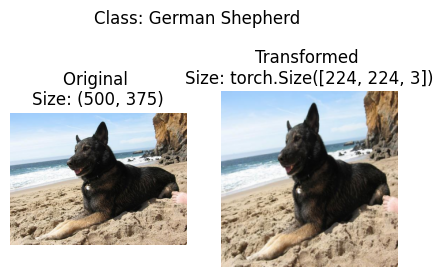

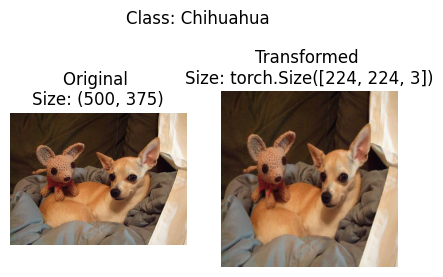

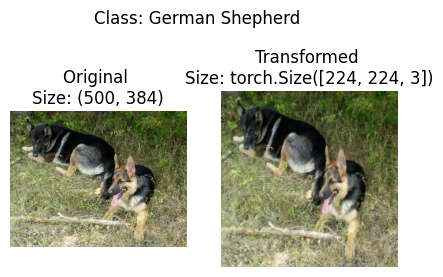

In [37]:
# Create Image List
images_list = list(root_dir.glob("*/*/*.jpg"))
images_list.extend(root_dir.glob("*/*/*.jpeg"))


# Plot Images after transforming
hlp.plot_transformed_images(image_paths=images_list, transform=simple_transform, n=3)

## 3. Group Data to batches

In [38]:
# Setup batch size and number of works
BATCH_SIZE = 32
NUM_WORKERS = 2

# Create DataLoader's
train_dataloader_simple = DataLoader(dataset=train_data_simple, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x1795d96e570>,
 <torch.utils.data.dataloader.DataLoader at 0x1795d96c200>)

## 4. Design Model

In [39]:
IN_CHANNELS     = 3   # Color Channels
HIDDEN_UNITS    = 10
OUTPUT_SHAPE = len(train_data_simple.classes)
SIMPLE_MODEL_PATH = 'simple_model.pth'


simple_model = nn.Sequential(
    nn.Conv2d(in_channels=IN_CHANNELS, out_channels=HIDDEN_UNITS, kernel_size=3, stride=1,  padding=0), 
    nn.ReLU(),
    nn.Conv2d(in_channels=HIDDEN_UNITS, out_channels=HIDDEN_UNITS, kernel_size=3, stride=1, padding=0),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(HIDDEN_UNITS, HIDDEN_UNITS, kernel_size=3, padding=0),
    nn.ReLU(),
    nn.Conv2d(HIDDEN_UNITS, HIDDEN_UNITS, kernel_size=3, padding=0),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(in_features=HIDDEN_UNITS*53*53, out_features=OUTPUT_SHAPE)
).to(device)

try:
    simple_model.load_state_dict(torch.load(f=SIMPLE_MODEL_PATH))
except FileNotFoundError:
    pass

simple_model

Sequential(
  (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (6): ReLU()
  (7): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Linear(in_features=28090, out_features=4, bias=True)
)

In [40]:
# Verify Model using torchinfo.summary
summary(simple_model, input_size=[1, 3, IMAGE_X, IMAGE_Y])

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 4]                    --
├─Conv2d: 1-1                            [1, 10, 222, 222]         280
├─ReLU: 1-2                              [1, 10, 222, 222]         --
├─Conv2d: 1-3                            [1, 10, 220, 220]         910
├─ReLU: 1-4                              [1, 10, 220, 220]         --
├─MaxPool2d: 1-5                         [1, 10, 110, 110]         --
├─Conv2d: 1-6                            [1, 10, 108, 108]         910
├─ReLU: 1-7                              [1, 10, 108, 108]         --
├─Conv2d: 1-8                            [1, 10, 106, 106]         910
├─ReLU: 1-9                              [1, 10, 106, 106]         --
├─MaxPool2d: 1-10                        [1, 10, 53, 53]           --
├─Flatten: 1-11                          [1, 28090]                --
├─Linear: 1-12                           [1, 4]                    112,364
Total 

## 5. Train Model

In [41]:
# Number of epochs
NUM_EPOCHS = 10

# Setup loss function and optimizer
loss_fn_simple   = nn.CrossEntropyLoss()
optimizer_simple = torch.optim.Adam(params=simple_model.parameters(), lr=0.001)

simple_model_results = hlp.train_model(model=simple_model, train_dataloader=train_dataloader_simple, test_dataloader=test_dataloader_simple, 
                                       optimizer=optimizer_simple, loss_fn=loss_fn_simple, epochs=NUM_EPOCHS, device=device)

# Save Model
torch.save(obj=simple_model.state_dict(),f=SIMPLE_MODEL_PATH)

 10%|█         | 1/10 [00:15<02:15, 15.09s/it]

Epoch: 1 | train_loss: 1.4156 | train_acc: 0.2431 | test_loss: 1.3564 | test_acc: 0.4453


 20%|██        | 2/10 [00:29<01:56, 14.52s/it]

Epoch: 2 | train_loss: 1.3209 | train_acc: 0.3931 | test_loss: 1.2205 | test_acc: 0.4583


 30%|███       | 3/10 [00:42<01:38, 14.14s/it]

Epoch: 3 | train_loss: 1.2129 | train_acc: 0.4021 | test_loss: 1.1344 | test_acc: 0.4740


 40%|████      | 4/10 [00:56<01:24, 14.07s/it]

Epoch: 4 | train_loss: 1.1415 | train_acc: 0.4681 | test_loss: 1.0983 | test_acc: 0.4766


 50%|█████     | 5/10 [01:10<01:09, 13.98s/it]

Epoch: 5 | train_loss: 1.0829 | train_acc: 0.5375 | test_loss: 1.1067 | test_acc: 0.4635


 60%|██████    | 6/10 [01:24<00:55, 13.93s/it]

Epoch: 6 | train_loss: 1.0491 | train_acc: 0.5569 | test_loss: 1.0873 | test_acc: 0.4766


 70%|███████   | 7/10 [01:38<00:41, 13.90s/it]

Epoch: 7 | train_loss: 1.0141 | train_acc: 0.5632 | test_loss: 1.1904 | test_acc: 0.4427


 80%|████████  | 8/10 [01:52<00:27, 13.92s/it]

Epoch: 8 | train_loss: 0.9683 | train_acc: 0.6000 | test_loss: 1.0573 | test_acc: 0.4870


 90%|█████████ | 9/10 [02:06<00:13, 13.90s/it]

Epoch: 9 | train_loss: 0.8589 | train_acc: 0.6708 | test_loss: 1.0893 | test_acc: 0.4844


100%|██████████| 10/10 [02:19<00:00, 14.00s/it]

Epoch: 10 | train_loss: 0.7670 | train_acc: 0.6993 | test_loss: 1.1136 | test_acc: 0.4661


## 6. Evaluate Model

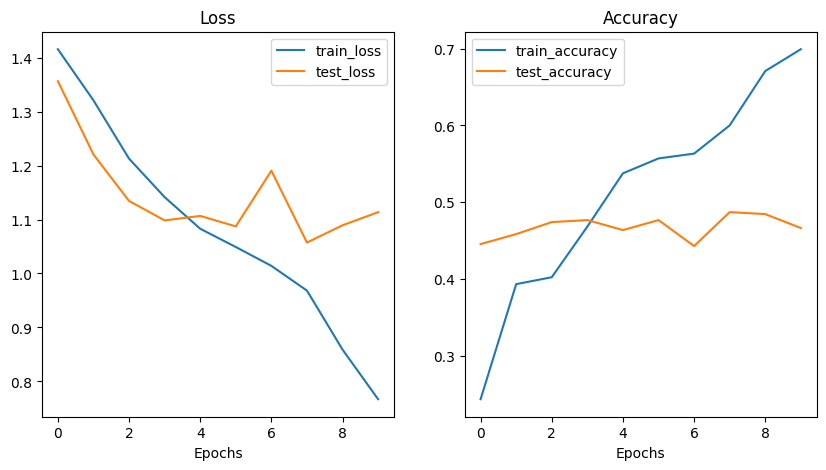

In [42]:
hlp.plot_loss_curves(simple_model_results)

## 7. Predict using custom data

Test Image:  dogs_test\german (4).jpg


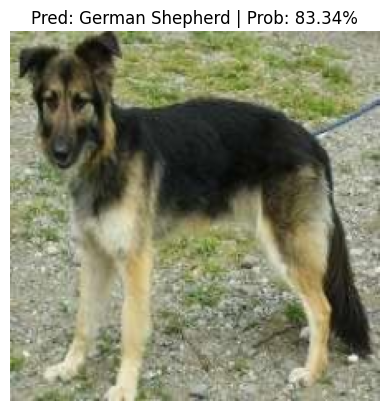

In [60]:
test_dir = Path('dogs_test')
test_images_list = list(test_dir.glob("*.jpg"))
test_images_list.extend(test_dir.glob("*.jpeg"))

custom_image_transform = transforms.Compose([transforms.Resize(IMAGE_SIZE),])

random_image_paths = random.sample(test_images_list, k=1)

print('Test Image: ', random_image_paths[0])
hlp.pred_and_plot_image(model=simple_model, image_path=random_image_paths[0], class_names=class_names, transform=custom_image_transform, device=device)

## 8. Trying a pretrained model 

In [61]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
auto_transforms = weights.transforms()

# Turn images into DataLoaders
train_dataloader = DataLoader(train_data_simple, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True )

test_dataloader  = DataLoader(test_data_simple , batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

auto_transforms, train_dataloader, test_dataloader

(ImageClassification(
     crop_size=[224]
     resize_size=[256]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BICUBIC
 ),
 <torch.utils.data.dataloader.DataLoader at 0x1795ba67380>)

In [62]:
TRAINED_MODEL_PATH = 'trained_model.pth'

trained_model = torchvision.models.efficientnet_b0(weights=weights).to(device)

for param in trained_model.features.parameters():
  param.requires_grad = False

trained_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names))
    ).to(device)

try:
    trained_model.load_state_dict(torch.load(f=TRAINED_MODEL_PATH))
except FileNotFoundError:
    pass

trained_model 

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [63]:
summary(model=trained_model,input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 4]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [64]:
# Number of epochs
NUM_EPOCHS = 10

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=trained_model.parameters(), lr=0.001)

trained_model_results = hlp.train_model(model=trained_model, train_dataloader=train_dataloader, test_dataloader=test_dataloader, 
                                       optimizer=optimizer, loss_fn=loss_fn, epochs=NUM_EPOCHS, device=device)

# Save Model
torch.save(obj=simple_model.state_dict(),f=TRAINED_MODEL_PATH)

 10%|█         | 1/10 [00:15<02:15, 15.07s/it]

Epoch: 1 | train_loss: 1.1176 | train_acc: 0.6292 | test_loss: 0.8356 | test_acc: 0.8880


 20%|██        | 2/10 [00:29<01:56, 14.56s/it]

Epoch: 2 | train_loss: 0.6594 | train_acc: 0.9125 | test_loss: 0.4733 | test_acc: 0.9505


 30%|███       | 3/10 [00:43<01:40, 14.37s/it]

Epoch: 3 | train_loss: 0.4526 | train_acc: 0.9278 | test_loss: 0.3276 | test_acc: 0.9688


 40%|████      | 4/10 [00:57<01:25, 14.28s/it]

Epoch: 4 | train_loss: 0.3771 | train_acc: 0.9403 | test_loss: 0.2649 | test_acc: 0.9583


 50%|█████     | 5/10 [01:12<01:11, 14.36s/it]

Epoch: 5 | train_loss: 0.3378 | train_acc: 0.9278 | test_loss: 0.2342 | test_acc: 0.9688


 60%|██████    | 6/10 [01:26<00:57, 14.32s/it]

Epoch: 6 | train_loss: 0.2802 | train_acc: 0.9514 | test_loss: 0.2223 | test_acc: 0.9609


 70%|███████   | 7/10 [01:40<00:43, 14.35s/it]

Epoch: 7 | train_loss: 0.2417 | train_acc: 0.9576 | test_loss: 0.1978 | test_acc: 0.9583


 80%|████████  | 8/10 [01:54<00:28, 14.32s/it]

Epoch: 8 | train_loss: 0.2396 | train_acc: 0.9507 | test_loss: 0.1929 | test_acc: 0.9766


 90%|█████████ | 9/10 [02:09<00:14, 14.34s/it]

Epoch: 9 | train_loss: 0.2225 | train_acc: 0.9590 | test_loss: 0.1856 | test_acc: 0.9688


100%|██████████| 10/10 [02:23<00:00, 14.36s/it]

Epoch: 10 | train_loss: 0.1895 | train_acc: 0.9812 | test_loss: 0.1747 | test_acc: 0.9583


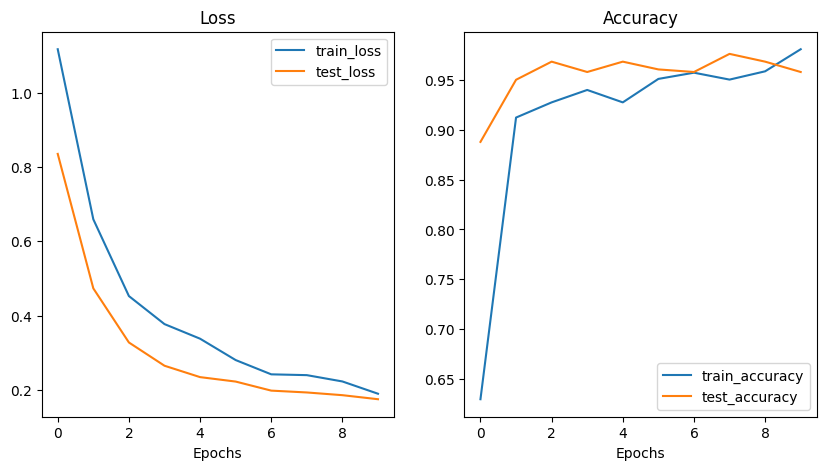

In [65]:
hlp.plot_loss_curves(trained_model_results)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].


Test Image:  dogs_test\chiuaua (1).jpg


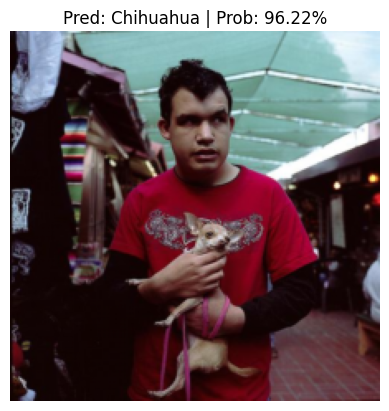

In [96]:
random_image_paths = random.sample(test_images_list, k=1)

print('Test Image: ', random_image_paths[0])
hlp.pred_and_plot_image(model=trained_model, image_path=random_image_paths[0], class_names=class_names, transform=custom_image_transform, device=device)